# Project 2: Clustering: Kmeans, GMM

## Kmeans

In [1]:
import findspark
findspark.init()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.functions import col, udf
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row


In [3]:
# ML Imports
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans, GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.types import DoubleType

### KHỞI TẠO SPARK

In [4]:
# KHỞI TẠO SPARK
sc = SparkContext()
spark = SparkSession.builder.appName('ReadExcel').getOrCreate()

### ĐỌC VÀ LÀM SẠCH DỮ LIỆU BẰNG PANDAS

In [5]:
# ĐỌC VÀ LÀM SẠCH DỮ LIỆU BẰNG PANDAS
pdf = pd.read_excel('./Data/data_motobikes.xlsx', sheet_name='Sheet1')

In [6]:
# Chuyển đổi kiểu dữ liệu cột 'Giá', 'Khoảng giá min', 'Khoảng giá max' từ object sang float với đơn vị triệu đồng
pdf['Giá'] = (pdf['Giá'].str.replace(" đ","",regex=False).str.replace(".","",regex=False).astype(float)) / 1000000
pdf['Khoảng giá min'] = (pdf['Khoảng giá min'].str.replace(" tr","",regex=False).astype(float))
pdf['Khoảng giá max'] = (pdf['Khoảng giá max'].str.replace(" tr","",regex=False).astype(float))

In [7]:
# chuyển đổi dữ liệu cột năm đăng ký sang số
pdf['Năm đăng ký'] = pd.to_numeric(pdf['Năm đăng ký'], errors='coerce')
pdf['Năm đăng ký'] = pdf['Năm đăng ký'].fillna(pdf['Năm đăng ký'].median())

In [8]:
text_columns = ['Thương hiệu','Dòng xe','Loại xe', 'Dung tích xe','Xuất xứ']
for c in text_columns:
    pdf[c] = pdf[c].fillna('').astype(str)

In [9]:
# Xóa dòng dữ liệu có Dung tích xe là 'Không biết rõ' và 'Đang cập nhật' và 'Nhật Bản'
pdf = pdf[pdf['Dung tích xe'] != 'Không biết rõ']
pdf = pdf[pdf['Dung tích xe'] != 'Đang cập nhật']
pdf = pdf[pdf['Dung tích xe'] != 'Nhật Bản']

#### LOẠI BỎ OUTLIERS

In [10]:
# thêm cột log_gia
pdf['log_gia'] = np.log1p(pdf['Giá'])
# xóa outlier cột log (Giá)
mean_val = pdf['log_gia'].mean()

stddev_val = pdf['log_gia'].std()

#Create three standard deviation (u+- 3sigma) lower and upper bounds for data
low_bound = mean_val - (3 * stddev_val)
high_bound = mean_val + (3 * stddev_val)

# Filter the data to fit between the lower and upper bounds
pdf = pdf[
    (pdf["log_gia"] < high_bound) & 
    (pdf["log_gia"] > low_bound)
    ]
pdf.count()

id                     7114
Tiêu đề                7114
Giá                    7114
Khoảng giá min         6922
Khoảng giá max         6927
Địa chỉ                7076
Mô tả chi tiết         7114
Thương hiệu            7114
Dòng xe                7114
Năm đăng ký            7114
Số Km đã đi            7114
Tình trạng             7114
Loại xe                7114
Dung tích xe           7114
Xuất xứ                7114
Chính sách bảo hành    7113
Trọng lượng            7113
Href                   7114
log_gia                7114
dtype: int64

### CHUYỂN SANG SPARK DATAFRAME VÀ XỬ LÝ

In [11]:
df = spark.createDataFrame(pdf)
df.show()

+---+--------------------+-----+--------------+--------------+--------------------+--------------------+-----------+---------+-----------+-----------+----------+------------+------------+-------------+-------------------+-----------+--------------------+------------------+
| id|             Tiêu đề|  Giá|Khoảng giá min|Khoảng giá max|             Địa chỉ|      Mô tả chi tiết|Thương hiệu|  Dòng xe|Năm đăng ký|Số Km đã đi|Tình trạng|     Loại xe|Dung tích xe|      Xuất xứ|Chính sách bảo hành|Trọng lượng|                Href|           log_gia|
+---+--------------------+-----+--------------+--------------+--------------------+--------------------+-----------+---------+-----------+-----------+----------+------------+------------+-------------+-------------------+-----------+--------------------+------------------+
|  1|Bán Vespa Sprint ...| 66.0|         72.53|         85.14|Phường Bến Thành,...|Bán xe #Vespa Spr...|    Piaggio|    Vespa|     2024.0|      14000|Đã sử dụng|      Tay ga|100 

In [12]:
df_sub = df.select('id','Giá', 'Khoảng giá min', 'Khoảng giá max', 'Thương hiệu', 'Dòng xe', 'Năm đăng ký', 'Số Km đã đi', 'Loại xe', 'Dung tích xe', 'Xuất xứ')
df_sub.show(5)

+---+----+--------------+--------------+-----------+-------+-----------+-----------+-------+------------+-------------+
| id| Giá|Khoảng giá min|Khoảng giá max|Thương hiệu|Dòng xe|Năm đăng ký|Số Km đã đi|Loại xe|Dung tích xe|      Xuất xứ|
+---+----+--------------+--------------+-----------+-------+-----------+-----------+-------+------------+-------------+
|  1|66.0|         72.53|         85.14|    Piaggio|  Vespa|     2024.0|      14000| Tay ga|100 - 175 cc|Đang cập nhật|
|  2|79.5|         62.76|         73.68|      Honda|     SH|     2019.0|      28000| Tay ga|100 - 175 cc|Đang cập nhật|
|  3|37.0|          28.0|         32.86|      Honda| Vision|     2023.0|      12000| Tay ga|100 - 175 cc|Đang cập nhật|
|  4|45.0|          43.1|          50.6|    Piaggio|  Vespa|     2019.0|      60000| Tay ga|100 - 175 cc|Đang cập nhật|
|  5|23.0|         17.02|         19.98|     Yamaha|  Latte|     2021.0|      24000| Tay ga|100 - 175 cc|     Nhật Bản|
+---+----+--------------+--------------+

In [13]:
df_sub.printSchema()

root
 |-- id: long (nullable = true)
 |-- Giá: double (nullable = true)
 |-- Khoảng giá min: double (nullable = true)
 |-- Khoảng giá max: double (nullable = true)
 |-- Thương hiệu: string (nullable = true)
 |-- Dòng xe: string (nullable = true)
 |-- Năm đăng ký: double (nullable = true)
 |-- Số Km đã đi: long (nullable = true)
 |-- Loại xe: string (nullable = true)
 |-- Dung tích xe: string (nullable = true)
 |-- Xuất xứ: string (nullable = true)



In [14]:
# Drop any records with NULL values
df_sub = df_sub.dropna()

In [15]:
# Loại bỏ duplicates
df_sub = df_sub.drop_duplicates()

In [16]:
df_sub.show(5)

+---+---------+--------------+--------------+-----------+---------+-----------+-----------+-------+------------+-------------+
| id|      Giá|Khoảng giá min|Khoảng giá max|Thương hiệu|  Dòng xe|Năm đăng ký|Số Km đã đi|Loại xe|Dung tích xe|      Xuất xứ|
+---+---------+--------------+--------------+-----------+---------+-----------+-----------+-------+------------+-------------+
|339|     13.2|         19.42|          22.8|     Yamaha|      Nvx|     2017.0|      35000| Tay ga|100 - 175 cc|Đang cập nhật|
|171|12.345678|          98.4|        115.51|      Honda|       SH|     2010.0|      50000| Tay ga|100 - 175 cc|    Nước khác|
|191|     12.0|          8.67|         10.17|      Honda|Dòng khác|     2007.0|      10000| Tay ga|  Dưới 50 cc|     Nhật Bản|
|479|    120.0|        111.87|        131.33|      Honda|       SH|     2011.0|      38000| Tay ga|100 - 175 cc|Đang cập nhật|
|509|     22.8|          15.9|         18.67|      Honda|Air Blade|     2015.0|      14000| Tay ga|100 - 175 cc

In [17]:
# Kiểm tra lại kiểu dữ liệu và một vài dòng
df_sub.printSchema()

root
 |-- id: long (nullable = true)
 |-- Giá: double (nullable = true)
 |-- Khoảng giá min: double (nullable = true)
 |-- Khoảng giá max: double (nullable = true)
 |-- Thương hiệu: string (nullable = true)
 |-- Dòng xe: string (nullable = true)
 |-- Năm đăng ký: double (nullable = true)
 |-- Số Km đã đi: long (nullable = true)
 |-- Loại xe: string (nullable = true)
 |-- Dung tích xe: string (nullable = true)
 |-- Xuất xứ: string (nullable = true)



In [18]:
df_sub.show()

+---+---------+--------------+--------------+-----------+---------+-----------+-----------+------------+------------+-------------+
| id|      Giá|Khoảng giá min|Khoảng giá max|Thương hiệu|  Dòng xe|Năm đăng ký|Số Km đã đi|     Loại xe|Dung tích xe|      Xuất xứ|
+---+---------+--------------+--------------+-----------+---------+-----------+-----------+------------+------------+-------------+
|339|     13.2|         19.42|          22.8|     Yamaha|      Nvx|     2017.0|      35000|      Tay ga|100 - 175 cc|Đang cập nhật|
|171|12.345678|          98.4|        115.51|      Honda|       SH|     2010.0|      50000|      Tay ga|100 - 175 cc|    Nước khác|
|191|     12.0|          8.67|         10.17|      Honda|Dòng khác|     2007.0|      10000|      Tay ga|  Dưới 50 cc|     Nhật Bản|
|479|    120.0|        111.87|        131.33|      Honda|       SH|     2011.0|      38000|      Tay ga|100 - 175 cc|Đang cập nhật|
|509|     22.8|          15.9|         18.67|      Honda|Air Blade|     2015

### ENCODE VÀ CHUẨN HÓA DỮ LIỆU

In [19]:
# String index transformation
cat_cols = ['Thương hiệu','Dòng xe','Loại xe', 'Dung tích xe','Xuất xứ']
indexed_cols = [col + "_indexed" for col in cat_cols]
indexer = StringIndexer(inputCols=cat_cols, outputCols=indexed_cols)
indexed_df = indexer.fit(df_sub).transform(df_sub)

In [20]:
indexed_df.show()

+---+---------+--------------+--------------+-----------+---------+-----------+-----------+------------+------------+-------------+-------------------+---------------+---------------+--------------------+---------------+
| id|      Giá|Khoảng giá min|Khoảng giá max|Thương hiệu|  Dòng xe|Năm đăng ký|Số Km đã đi|     Loại xe|Dung tích xe|      Xuất xứ|Thương hiệu_indexed|Dòng xe_indexed|Loại xe_indexed|Dung tích xe_indexed|Xuất xứ_indexed|
+---+---------+--------------+--------------+-----------+---------+-----------+-----------+------------+------------+-------------+-------------------+---------------+---------------+--------------------+---------------+
|339|     13.2|         19.42|          22.8|     Yamaha|      Nvx|     2017.0|      35000|      Tay ga|100 - 175 cc|Đang cập nhật|                1.0|           27.0|            0.0|                 0.0|            2.0|
|171|12.345678|          98.4|        115.51|      Honda|       SH|     2010.0|      50000|      Tay ga|100 - 175 cc

In [21]:
indexed_df.select('Giá','Số Km đã đi','Thương hiệu_indexed','Dòng xe_indexed', 'Loại xe_indexed','Dung tích xe_indexed', 'Xuất xứ_indexed', 'Năm đăng ký').show(5)

+---------+-----------+-------------------+---------------+---------------+--------------------+---------------+-----------+
|      Giá|Số Km đã đi|Thương hiệu_indexed|Dòng xe_indexed|Loại xe_indexed|Dung tích xe_indexed|Xuất xứ_indexed|Năm đăng ký|
+---------+-----------+-------------------+---------------+---------------+--------------------+---------------+-----------+
|     13.2|      35000|                1.0|           27.0|            0.0|                 0.0|            2.0|     2017.0|
|12.345678|      50000|                0.0|            1.0|            0.0|                 0.0|            3.0|     2010.0|
|     12.0|      10000|                0.0|            3.0|            0.0|                 2.0|            1.0|     2007.0|
|    120.0|      38000|                0.0|            1.0|            0.0|                 0.0|            2.0|     2011.0|
|     22.8|      14000|                0.0|            2.0|            0.0|                 0.0|            1.0|     2015.0|


### Data transformation

In [22]:
cols = ['Giá', 'Số Km đã đi', 'Dung tích xe_indexed', 'Năm đăng ký']
data = indexed_df.select(cols)

In [23]:
data.show()

+---------+-----------+--------------------+-----------+
|      Giá|Số Km đã đi|Dung tích xe_indexed|Năm đăng ký|
+---------+-----------+--------------------+-----------+
|     13.2|      35000|                 0.0|     2017.0|
|12.345678|      50000|                 0.0|     2010.0|
|     12.0|      10000|                 2.0|     2007.0|
|    120.0|      38000|                 0.0|     2011.0|
|     22.8|      14000|                 0.0|     2015.0|
|      4.0|      40000|                 0.0|     2023.0|
|     23.5|      45000|                 0.0|     2022.0|
|     11.2|      24700|                 0.0|     2021.0|
|     20.0|         50|                 0.0|     2012.0|
|    140.0|      20000|                 3.0|     2016.0|
|     43.6|       9000|                 0.0|     2023.0|
|     43.5|      29800|                 0.0|     2010.0|
|     30.0|         50|                 2.0|     2015.0|
|     27.5|      21000|                 0.0|     2021.0|
|     15.0|      90000|        

In [24]:
vec_assembler = VectorAssembler(inputCols=data.columns,
                                 outputCol="features")


In [25]:
final_data = vec_assembler.transform(data)

### Data Scale

In [26]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withMean=True, withStd=True)

In [27]:
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

In [28]:
# Normalize each feature to have unit standard deviation.
final_data = scalerModel.transform(final_data)

In [29]:
final_data.show(5,False)

+---------+-----------+--------------------+-----------+------------------------------+------------------------------------------------------------------------------------+
|Giá      |Số Km đã đi|Dung tích xe_indexed|Năm đăng ký|features                      |scaledFeatures                                                                      |
+---------+-----------+--------------------+-----------+------------------------------+------------------------------------------------------------------------------------+
|13.2     |35000      |0.0                 |2017.0     |[13.2,35000.0,0.0,2017.0]     |[-0.41134930124853153,-0.21521910402441669,-0.40045216605941125,0.4113631974286914] |
|12.345678|50000      |0.0                 |2010.0     |[12.345678,50000.0,0.0,2010.0]|[-0.43506966120065416,-0.10560234381730534,-0.40045216605941125,-0.5843502788508147]|
|12.0     |10000      |2.0                 |2007.0     |[12.0,10000.0,2.0,2007.0]     |[-0.44466745522624385,-0.3979137043696022,2.4065

### TÌM K TỐI ƯU CHO K-MEANS

In [30]:
k_list = []
silhouette_list = []
sil_str = ""
for k in range(2,11):
    kmeans = KMeans(featuresCol='scaledFeatures',k=k)
    model = kmeans.fit(final_data)
    k_list.append(k)
    # silhoutte
    predictions_k = model.transform(final_data)
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions_k)
    silhouette_list.append(silhouette)
    sil_str = sil_str + "With k =" + str(k) + "- Silhouette = " + str(silhouette) + "\n"

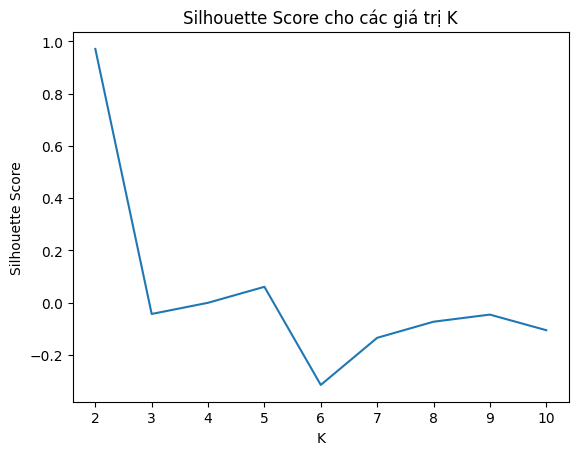

In [31]:
plt.plot(k_list, silhouette_list)
plt.title("Silhouette Score cho các giá trị K")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.show()

In [32]:
print(sil_str)

With k =2- Silhouette = 0.9711757711876856
With k =3- Silhouette = -0.043093173015828594
With k =4- Silhouette = -0.00027740090492564057
With k =5- Silhouette = 0.060840643588490693
With k =6- Silhouette = -0.3146288464103876
With k =7- Silhouette = -0.13443183237926998
With k =8- Silhouette = -0.07277653450830075
With k =9- Silhouette = -0.04550429029925815
With k =10- Silhouette = -0.10519422652809192



- Tìm k bằng Elbow

In [33]:
# Xác định phạm vi K để kiểm tra
k_values = range(2, 10) 
wssse_list = []

for k in k_values:
    # 1. Khởi tạo mô hình K-Means
    kmeans = KMeans(featuresCol="scaledFeatures", k=k, seed=1)

    # 2. Huấn luyện mô hình
    model = kmeans.fit(final_data)

    # 3. Tính WSSSE (trainingCost)
    wssse = model.summary.trainingCost 
    wssse_list.append(wssse)
    print(f"K={k}, WSSSE: {wssse}")

K=2, WSSSE: 22145.118664934806
K=3, WSSSE: 17418.866322616894
K=4, WSSSE: 12334.163116924143
K=5, WSSSE: 9904.83413137822
K=6, WSSSE: 8233.810793527942
K=7, WSSSE: 7559.981235366871
K=8, WSSSE: 6503.468602282065
K=9, WSSSE: 5923.29983514018


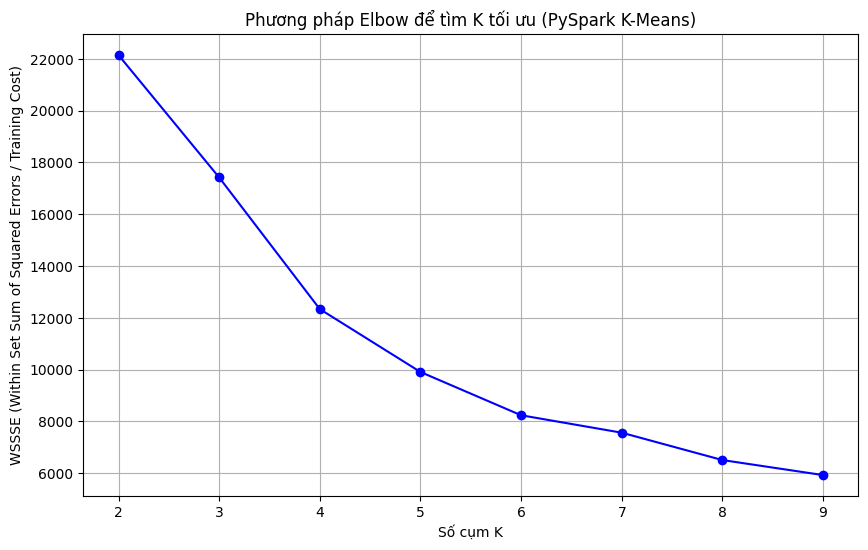

In [34]:
# Chuyển đổi sang mảng numpy để vẽ biểu đồ
import numpy as np
k_np = np.array(k_values)
wssse_np = np.array(wssse_list)

# Vẽ biểu đồ Elbow
plt.figure(figsize=(10, 6))
plt.plot(k_np, wssse_np, marker='o', linestyle='-', color='blue')
plt.title('Phương pháp Elbow để tìm K tối ưu (PySpark K-Means)')
plt.xlabel('Số cụm K')
plt.ylabel('WSSSE (Within Set Sum of Squared Errors / Training Cost)')
plt.xticks(k_np)
plt.grid(True)
plt.show()

### HUẤN LUYỆN K-MEANS VỚI K=3 

In [35]:
# Trains a k-means model with k = 3.
kmeans = KMeans(featuresCol='scaledFeatures', k=3)
model = kmeans.fit(final_data)

In [36]:
# Predict cluster labels
predictions = model.transform(final_data)
# Evaluate clustering by computing Silhouette score 
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette = " + str(silhouette))

Silhouette = -0.043093173015828594


In [37]:
# Show the result
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[-0.11200075 -0.1798489  -0.26323567  0.03190259]
[-0.30696893  4.2308267   0.02397661 -0.48609873]
[ 1.30780285 -0.24570642  2.70355366 -0.08770723]


## Dự đoán kết quả

In [38]:
predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  291|
|         2|  586|
|         0| 6045|
+----------+-----+



In [39]:
# Chọn các cột gốc và cột nhãn cụm
data_show = predictions.select(*final_data, "prediction")

# Đổi tên cột nhãn cụm (Tùy chọn)
data_show = data_show.withColumnRenamed("prediction", "cluster_kmeans").drop("features","scaledFeatures")

data_show.show(5)

+---------+-----------+--------------------+-----------+--------------+
|      Giá|Số Km đã đi|Dung tích xe_indexed|Năm đăng ký|cluster_kmeans|
+---------+-----------+--------------------+-----------+--------------+
|     13.2|      35000|                 0.0|     2017.0|             0|
|12.345678|      50000|                 0.0|     2010.0|             0|
|     12.0|      10000|                 2.0|     2007.0|             2|
|    120.0|      38000|                 0.0|     2011.0|             0|
|     22.8|      14000|                 0.0|     2015.0|             0|
+---------+-----------+--------------------+-----------+--------------+
only showing top 5 rows



In [40]:
# Lấy nhãn
labels_kmeans = predictions.select("prediction")

In [41]:
# chuyển đổi nhãn sang dạng DataFrame Pandas
labels_kmeans_pd = labels_kmeans.toPandas()

In [42]:
# Chuyển đổi dataframe pysparkgốc sang pandas
df_pd = df.toPandas()

In [43]:
# Gán với dataframe gốc pandas
df_pd['kmeans_cluster'] = labels_kmeans_pd['prediction']

In [44]:
# Hiển thị kết quả cuối cùng
df_pd.head()


,id,Tiêu đề,Giá,Khoảng giá min,Khoảng giá max,Địa chỉ,Mô tả chi tiết,Thương hiệu,Dòng xe,Năm đăng ký,Số Km đã đi,Tình trạng,Loại xe,Dung tích xe,Xuất xứ,Chính sách bảo hành,Trọng lượng,Href,log_gia,kmeans_cluster
0,1,"Bán Vespa Sprint 125cc 2024 xanh dương, xe đẹp...",66.0,72.53,85.14,"Phường Bến Thành, Quận 1, Tp Hồ Chí Minh",Bán xe #Vespa Sprint 125cc. Mua mới tại #Topco...,Piaggio,Vespa,2024.0,14000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,4.204693,0.0
1,2,🔥🔥SH 150i Thắng ABS 2019 BSTP Chính Chủ,79.5,62.76,73.68,"Phường Tân Định, Quận 1, Tp Hồ Chí Minh","_Bán SH 150i Thắng ABS 2019 Xám Bạc, Úp Team X...",Honda,SH,2019.0,28000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,4.388257,0.0
2,3,CC Vision Thể Thao 2023 Đen+bộ đèn Demi audi A7,37.0,28.00,32.86,"Phường Cầu Kho, Quận 1, Tp Hồ Chí Minh",Chính chủ bán Vision phiên bản Thể Thao 2023 Đ...,Honda,Vision,2023.0,12000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,3.637586,2.0
3,4,Vespa Sprint 2019 -125- Đen Đỏ Sport -CHÍNH ...,45.0,43.10,50.60,"Phường Bến Nghé, Quận 1, Tp Hồ Chí Minh",XE CÁ NHÂN BÁN - XE DO EM ĐỨNG TÊN CHÍNH C...,Piaggio,Vespa,2019.0,60000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,3.828641,0.0
4,5,Xe tay ga Yamaha Latte 125 – Đăng ký 2021,23.0,17.02,19.98,"Phường Tân Định, Quận 1, Tp Hồ Chí Minh",🛵 Thông tin xe:\n\nDòng xe tay ga cao cấp Yama...,Yamaha,Latte,2021.0,24000,Đã sử dụng,Tay ga,100 - 175 cc,Nhật Bản,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,3.178054,0.0


### TRỰC QUAN HÓA K-MEANS BẰNG PCA

In [45]:
# 1. Áp dụng PCA để giảm 8 chiều 'scaledFeatures' xuống còn 2 chiều
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(predictions) # Dùng 'predictions' vì nó chứa kết quả cụm
pca_result = pca_model.transform(predictions)

In [46]:
# 2. Tách vector PCA 2 chiều ra thành 2 cột (pca_x, pca_y)
first_element_udf = udf(lambda v: float(v[0]), 'float')
second_element_udf = udf(lambda v: float(v[1]), 'float')
pca_result = pca_result.withColumn('pca_x', first_element_udf(col('pcaFeatures'))) \
                       .withColumn('pca_y', second_element_udf(col('pcaFeatures')))

pca_result.select("prediction", "pca_x", "pca_y").show(5)

+----------+------------+-----------+
|prediction|       pca_x|      pca_y|
+----------+------------+-----------+
|         0|  0.10835672| -0.6879551|
|         0|  0.66701984|-0.13245824|
|         2|  -0.1431671|  2.0743954|
|         0|  -1.4657643|  0.5106682|
|         0|0.0019634585| -0.5221345|
+----------+------------+-----------+
only showing top 5 rows



In [47]:
# 3. Chuyển sang Pandas để vẽ
df_pca = pca_result.select('pca_x', 'pca_y', 'prediction').toPandas()

In [48]:
from pyspark.ml.linalg import Vectors
centers_df = spark.createDataFrame(
    [(Vectors.dense(center), i) for i, center in enumerate(centers)], 
    ["scaledFeatures", "prediction"]
)
# Áp dụng biến đổi PCA lên các trung tâm cụm
pca_centers_result = pca_model.transform(centers_df)

# Tách vector PCA 2 chiều ra thành 2 cột (pca_x, pca_y) cho trung tâm
pca_centers_result = pca_centers_result.withColumn('pca_x', first_element_udf(col('pcaFeatures'))) \
                                       .withColumn('pca_y', second_element_udf(col('pcaFeatures')))

# Chuyển sang Pandas để vẽ
df_centers = pca_centers_result.select('pca_x', 'pca_y', 'prediction').toPandas()

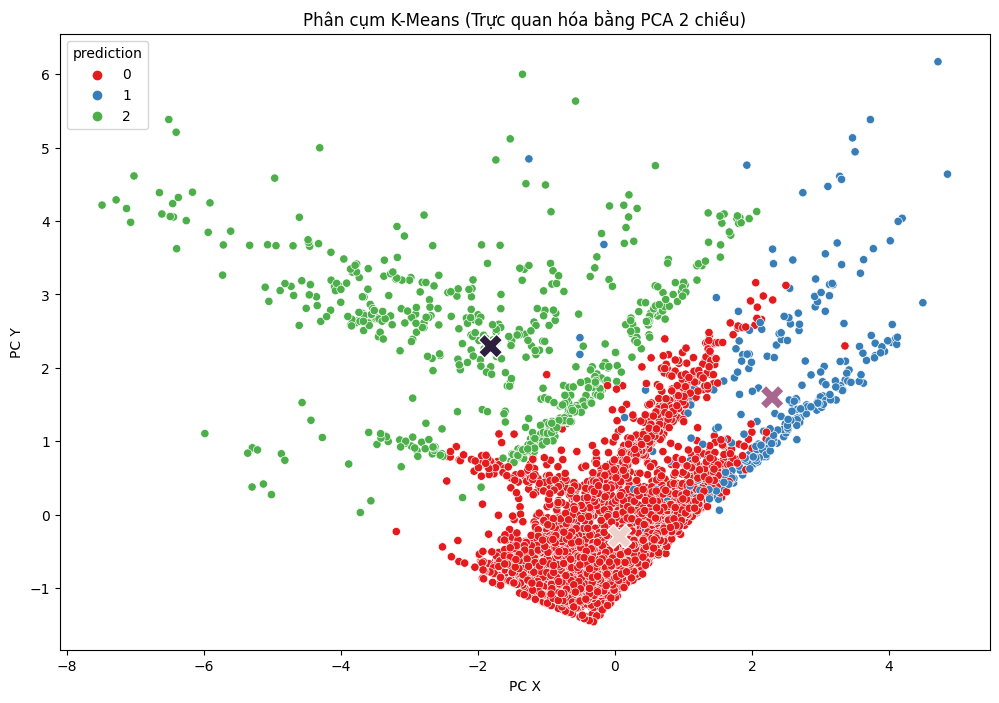

In [49]:
# 4. Vẽ biểu đồ
plt.figure(figsize=(12,8))
sns.scatterplot(x="pca_x", y="pca_y", data = df_pca,
                hue="prediction",
                palette="Set1")

# Các trung tâm cụm
sns.scatterplot(x="pca_x", 
                y="pca_y", 
                data = df_centers, # DataFrame của các trung tâm cụm
                hue="prediction",
                # palette="Set1",
                marker='X',
                color='red',
                s=300,
                legend=False,
                # edgecolor='black',
                linewidth=1,
                label="Trung tâm cụm")

plt.title("Phân cụm K-Means (Trực quan hóa bằng PCA 2 chiều)")
plt.xlabel("PC X")
plt.ylabel("PC Y")
plt.show()

### Gaussian Mixture Model (GMM)

- Tìm K bằng Silhouette

In [50]:
# TÌM K TỐI ƯU BẰNG SILHOUETTE SCORE

k_list = []
silhouette_list = []
sil_str = ""

for k in range(2,10):
    # Huấn luyện GMM
    gmm = GaussianMixture(k=k, featuresCol="scaledFeatures", seed=42)
    model = gmm.fit(final_data)
    k_list.append(k)
    # Tính silhouette scores
    predictions = model.transform(final_data)
    
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    
    silhouette_list.append(silhouette)
    sil_str = sil_str + "With k =" + str(k) + "- Silhouette = " + str(silhouette) + "\n"

In [51]:
# Kết quả và Chọn K (Silhouette)
id_max = np.argmax(silhouette_list)
optimal_k_silhouette = k_list[id_max]
max_score = silhouette_list[id_max]

In [52]:
print(f"Điểm Silhouette tối đa là {max_score:.4f}")
print(f"Số lượng thành phần (K) tối ưu là: {optimal_k_silhouette}")

Điểm Silhouette tối đa là 0.5878
Số lượng thành phần (K) tối ưu là: 2


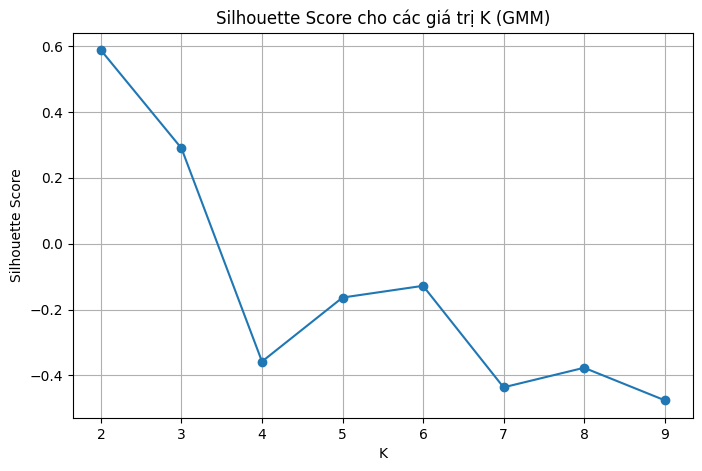

In [53]:
plt.figure(figsize=(8, 5))
plt.plot(k_list, silhouette_list, marker='o')
plt.title("Silhouette Score cho các giá trị K (GMM)")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [54]:
print(sil_str)

With k =2- Silhouette = 0.5878297666476576
With k =3- Silhouette = 0.2899265647478289
With k =4- Silhouette = -0.3579947132401943
With k =5- Silhouette = -0.16358628850509618
With k =6- Silhouette = -0.12791690379306017
With k =7- Silhouette = -0.4363318282504293
With k =8- Silhouette = -0.37689833176157633
With k =9- Silhouette = -0.4754754253676585



- Tìm K bằng Elbow

In [55]:
# TÌM K TỐI ƯU BẰNG WSSSE

k_values = range(2, 10)
wssse_list = []

gmm_feature_col = "scaledFeatures"

for k in k_values:
    # Huấn luyện GMM
    gmm = GaussianMixture(k=k, featuresCol=gmm_feature_col, seed=42)
    model = gmm.fit(final_data)
    
    # Lấy các trung tâm (means) của các thành phần Gaussian
    centers = [g.mean.toArray() for g in model.gaussians]

    # Dự đoán cụm
    predictions = model.transform(final_data)

    current_wssse = 0
    
    for i in range(k):
        # Lọc dữ liệu cho cụm i
        cluster_data = predictions.filter(col("prediction") == i)
        
        # Lấy tâm cụm i
        center_i = centers[i]
        
        # CÁCH TÍNH WSSSE BẰNG CLOSURE UDF (PySpark)
        def create_local_sq_euclidean_udf(center_val):
             def local_sq_euclidean(vector):                 
                 return float(np.sum((vector.toArray() - center_val) ** 2))             
             return udf(local_sq_euclidean, DoubleType())
             
        local_sq_euclidean_udf = create_local_sq_euclidean_udf(center_i)

        # Áp dụng UDF cục bộ, tính tổng bình phương khoảng cách
        wssse_i = cluster_data.withColumn(
            "sq_dist",
            local_sq_euclidean_udf(col(gmm_feature_col))
        ).agg({"sq_dist": "sum"}).collect()[0][0]
        
        # Thêm vào tổng WSSSE
        current_wssse += wssse_i
        
    wssse_list.append(current_wssse)
    print(f"K={k}: WSSSE = {current_wssse:.2f}")

K=2: WSSSE = 22307.93
K=3: WSSSE = 18710.35
K=4: WSSSE = 17239.66
K=5: WSSSE = 13081.44
K=6: WSSSE = 14568.14
K=7: WSSSE = 14470.49
K=8: WSSSE = 13482.72
K=9: WSSSE = 11470.27


In [56]:
# Trình bày Kết quả
print("KẾT QUẢ WSSSE:")
print(f"Danh sách WSSSE (cho K=2 đến 10): {wssse_list}")

KẾT QUẢ WSSSE:
Danh sách WSSSE (cho K=2 đến 10): [22307.93060800454, 18710.35398470185, 17239.65928730892, 13081.442089380453, 14568.144993066267, 14470.491938501038, 13482.724154517104, 11470.274093874046]


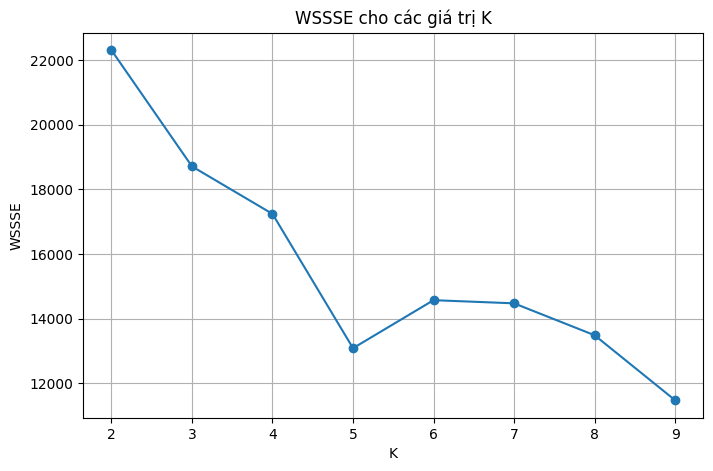

In [57]:
# Vẽ biểu đồ WSSSE
plt.figure(figsize=(8, 5))
plt.plot(k_values, wssse_list, marker='o')
plt.title("WSSSE cho các giá trị K")
plt.xlabel("K")
plt.ylabel("WSSSE")
plt.grid(True)
plt.show()

### HUẤN LUYỆN GMM VỚI K=3 

In [58]:
# Dùng 'final_data' và chỉ định 'scaledFeatures'
gmm = GaussianMixture(featuresCol='scaledFeatures').setK(3).setMaxIter(100).setSeed(42)
model_gmm = gmm.fit(final_data)

In [59]:
# Print model parameters
print("Gaussian weights:")
print(model_gmm.weights)
print("\nGaussian means:")
for i, gaussian in enumerate(model_gmm.gaussians):
    print(f"Cluster {i}: {gaussian.mean.toArray()}")
print("\nGaussian covariances:")
for i, gaussian in enumerate(model_gmm.gaussians):
    print(f"Cluster {i}:\n{gaussian.cov.toArray()}")

Gaussian weights:
[0.7507736825542352, 0.0919443945802137, 0.1572819228655511]

Gaussian means:
Cluster 0: [-0.11982562 -0.22286199 -0.40018209  0.13905553]
Cluster 1: [ 1.72230084 -0.20955995  2.00115996  0.17438467]
Cluster 2: [-0.43484964  1.18632058  0.74039494 -0.76571371]

Gaussian covariances:
Cluster 0:
[[ 3.08240440e-01 -1.48456102e-02  8.34596243e-04  1.80303507e-01]
 [-1.48456102e-02  6.24200212e-02  1.70926142e-03 -3.73288383e-02]
 [ 8.34596243e-04  1.70926142e-03  1.13709622e-03  3.42432208e-04]
 [ 1.80303507e-01 -3.73288383e-02  3.42432208e-04  7.09866418e-01]]
Cluster 1:
[[ 4.77573512  0.01535644 -0.81293237 -0.33948682]
 [ 0.01535644  0.24861144 -0.15936661 -0.06093801]
 [-0.81293237 -0.15936661  3.06244981  0.69610588]
 [-0.33948682 -0.06093801  0.69610588  0.98921854]]
Cluster 2:
[[ 0.10221957  0.07714819 -0.05732825  0.04619014]
 [ 0.07714819  4.24368703 -0.96261424  0.42856792]
 [-0.05732825 -0.96261424  0.90773122 -0.4594926 ]
 [ 0.04619014  0.42856792 -0.4594926  

In [60]:
# Make predictions
predictions_gmm = model_gmm.transform(final_data)

In [61]:
print("\nPredictions GMM:")
predictions_gmm.select("scaledFeatures", "prediction", "probability").show(truncate=False)


Predictions GMM:
+------------------------------------------------------------------------------------+----------+-----------------------------------------------------------------+
|scaledFeatures                                                                      |prediction|probability                                                      |
+------------------------------------------------------------------------------------+----------+-----------------------------------------------------------------+
|[-0.41134930124853153,-0.21521910402441669,-0.40045216605941125,0.4113631974286914] |0         |[0.9997265689524887,4.2443311722609415E-5,2.3098773578853927E-4] |
|[-0.43506966120065416,-0.10560234381730534,-0.40045216605941125,-0.5843502788508147]|0         |[0.9996351273697851,6.290246363876393E-5,3.0197016657609074E-4]  |
|[-0.44466745522624385,-0.3979137043696022,2.4065654475742515,-1.011084625827746]    |2         |[1.6040179484415904E-13,0.18619520738998777,0.813804792609852]   

In [62]:
# Lấy cột nhãn vào DataFrame ban đầu
# data_show= predictions_gmm.select(*final_data,"prediction")
labels_gmm= predictions_gmm.select("prediction")

In [63]:
# Chuyển đổi nhãn sang dạng DataFrame Pandas
labels_gmm_pd = labels_gmm.toPandas()

In [64]:
# Gán với dataframe gốc pandas
df_pd['gmm_cluster'] = labels_gmm_pd['prediction']

In [65]:
# Hiển thị kết quả cuối cùng
df_pd.head()

,id,Tiêu đề,Giá,Khoảng giá min,Khoảng giá max,Địa chỉ,Mô tả chi tiết,Thương hiệu,Dòng xe,Năm đăng ký,...,Tình trạng,Loại xe,Dung tích xe,Xuất xứ,Chính sách bảo hành,Trọng lượng,Href,log_gia,kmeans_cluster,gmm_cluster
0,1,"Bán Vespa Sprint 125cc 2024 xanh dương, xe đẹp...",66.0,72.53,85.14,"Phường Bến Thành, Quận 1, Tp Hồ Chí Minh",Bán xe #Vespa Sprint 125cc. Mua mới tại #Topco...,Piaggio,Vespa,2024.0,...,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,4.204693,0.0,0.0
1,2,🔥🔥SH 150i Thắng ABS 2019 BSTP Chính Chủ,79.5,62.76,73.68,"Phường Tân Định, Quận 1, Tp Hồ Chí Minh","_Bán SH 150i Thắng ABS 2019 Xám Bạc, Úp Team X...",Honda,SH,2019.0,...,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,4.388257,0.0,0.0
2,3,CC Vision Thể Thao 2023 Đen+bộ đèn Demi audi A7,37.0,28.00,32.86,"Phường Cầu Kho, Quận 1, Tp Hồ Chí Minh",Chính chủ bán Vision phiên bản Thể Thao 2023 Đ...,Honda,Vision,2023.0,...,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,3.637586,2.0,2.0
3,4,Vespa Sprint 2019 -125- Đen Đỏ Sport -CHÍNH ...,45.0,43.10,50.60,"Phường Bến Nghé, Quận 1, Tp Hồ Chí Minh",XE CÁ NHÂN BÁN - XE DO EM ĐỨNG TÊN CHÍNH C...,Piaggio,Vespa,2019.0,...,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,3.828641,0.0,1.0
4,5,Xe tay ga Yamaha Latte 125 – Đăng ký 2021,23.0,17.02,19.98,"Phường Tân Định, Quận 1, Tp Hồ Chí Minh",🛵 Thông tin xe:\n\nDòng xe tay ga cao cấp Yama...,Yamaha,Latte,2021.0,...,Đã sử dụng,Tay ga,100 - 175 cc,Nhật Bản,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,3.178054,0.0,0.0


### TRỰC QUAN HÓA GMM BẰNG PCA

In [66]:
gmm_means_8d = [g.mean for g in model_gmm.gaussians]

In [67]:
# Tạo DataFrame tạm thời cho các trung tâm 8D
rows = [Row(scaledFeatures=Vectors.dense(mean.toArray())) for mean in gmm_means_8d]
means_df = spark.createDataFrame(rows)

In [68]:
# Áp dụng PCA
pca_means_result = pca_model.transform(means_df)

pca_means_result = pca_means_result.withColumn('pca_mean_x', first_element_udf(col('pcaFeatures'))) \
                                   .withColumn('pca_mean_y', second_element_udf(col('pcaFeatures')))

df_pca_means = pca_means_result.select('pca_mean_x', 'pca_mean_y').toPandas()

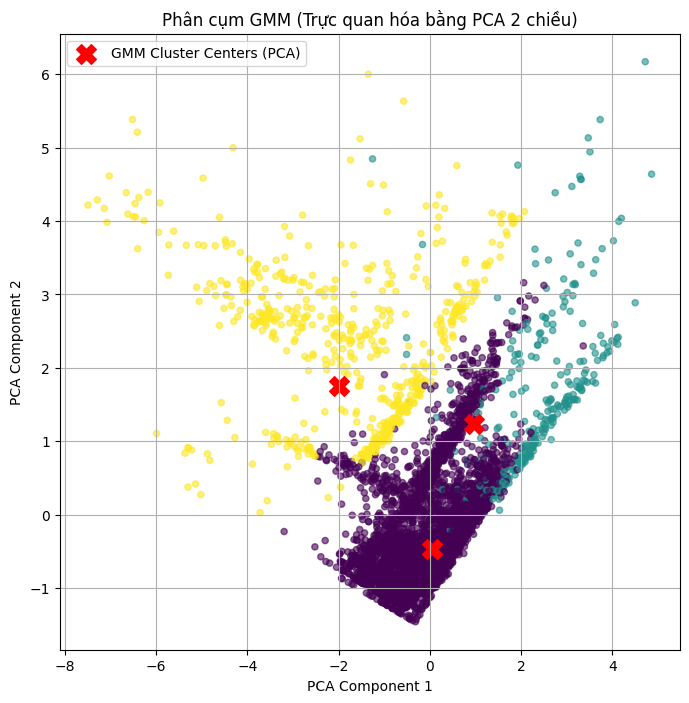

In [69]:
# Chuyển sang Pandas để vẽ (Đã có: df_pca và df_pca_means)

plt.figure(figsize=(8, 8))

# Vẽ các điểm dữ liệu đã giảm chiều bằng PCA
plt.scatter(df_pca['pca_x'], df_pca['pca_y'],
            c=df_pca['prediction'], 
            cmap='viridis', alpha=0.6, s=20)

# Vẽ các trung tâm cụm GMM đã được chuyển đổi bằng PCA
plt.scatter(df_pca_means['pca_mean_x'], df_pca_means['pca_mean_y'],
            color="red", marker='X', s=200, label='GMM Cluster Centers (PCA)')

plt.title("Phân cụm GMM (Trực quan hóa bằng PCA 2 chiều)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [70]:
spark.stop()

## Sklearn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

### ĐỌC VÀ LÀM SẠCH DỮ LIỆU BẰNG PANDAS

In [2]:
# ĐỌC VÀ LÀM SẠCH DỮ LIỆU BẰNG PANDAS
df = pd.read_excel('./Data/data_motobikes.xlsx', sheet_name='Sheet1')

# First 5 rows of the dataset
df.head()

,id,Tiêu đề,Giá,Khoảng giá min,Khoảng giá max,Địa chỉ,Mô tả chi tiết,Thương hiệu,Dòng xe,Năm đăng ký,Số Km đã đi,Tình trạng,Loại xe,Dung tích xe,Xuất xứ,Chính sách bảo hành,Trọng lượng,Href
0,1,"Bán Vespa Sprint 125cc 2024 xanh dương, xe đẹp...",66.000.000 đ,72.53 tr,85.14 tr,"Phường Bến Thành, Quận 1, Tp Hồ Chí Minh",Bán xe #Vespa Sprint 125cc. Mua mới tại #Topco...,Piaggio,Vespa,2024,14000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...
1,2,🔥🔥SH 150i Thắng ABS 2019 BSTP Chính Chủ,79.500.000 đ,62.76 tr,73.68 tr,"Phường Tân Định, Quận 1, Tp Hồ Chí Minh","_Bán SH 150i Thắng ABS 2019 Xám Bạc, Úp Team X...",Honda,SH,2019,28000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...
2,3,CC Vision Thể Thao 2023 Đen+bộ đèn Demi audi A7,37.000.000 đ,28 tr,32.86 tr,"Phường Cầu Kho, Quận 1, Tp Hồ Chí Minh",Chính chủ bán Vision phiên bản Thể Thao 2023 Đ...,Honda,Vision,2023,12000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...
3,4,Vespa Sprint 2019 -125- Đen Đỏ Sport -CHÍNH ...,45.000.000 đ,43.1 tr,50.6 tr,"Phường Bến Nghé, Quận 1, Tp Hồ Chí Minh",XE CÁ NHÂN BÁN - XE DO EM ĐỨNG TÊN CHÍNH C...,Piaggio,Vespa,2019,60000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...
4,5,Xe tay ga Yamaha Latte 125 – Đăng ký 2021,23.000.000 đ,17.02 tr,19.98 tr,"Phường Tân Định, Quận 1, Tp Hồ Chí Minh",🛵 Thông tin xe:\n\nDòng xe tay ga cao cấp Yama...,Yamaha,Latte,2021,24000,Đã sử dụng,Tay ga,100 - 175 cc,Nhật Bản,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...


In [3]:
# Chuyển đổi kiểu dữ liệu cột 'Giá', 'Khoảng giá min', 'Khoảng giá max' từ object sang float với đơn vị triệu đồng
df['Giá'] = (df['Giá'].str.replace(" đ","",regex=False).str.replace(".","",regex=False).astype(float)) / 1000000
df['Khoảng giá min'] = (df['Khoảng giá min'].str.replace(" tr","",regex=False).astype(float))
df['Khoảng giá max'] = (df['Khoảng giá max'].str.replace(" tr","",regex=False).astype(float))

In [4]:
# chuyển đổi dữ liệu cột năm đăng ký sang số
df['Năm đăng ký'] = pd.to_numeric(df['Năm đăng ký'], errors='coerce')
df['Năm đăng ký'] = df['Năm đăng ký'].fillna(df['Năm đăng ký'].median())

In [5]:
df.isnull().sum()

id                       0
Tiêu đề                  1
Giá                      2
Khoảng giá min         202
Khoảng giá max         197
Địa chỉ                 41
Mô tả chi tiết           0
Thương hiệu              3
Dòng xe                  3
Năm đăng ký              0
Số Km đã đi              0
Tình trạng               0
Loại xe                  0
Dung tích xe             0
Xuất xứ                  0
Chính sách bảo hành      1
Trọng lượng              1
Href                     0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
# Loại bỏ duplicates
df = df.drop_duplicates()

In [8]:
dung_tich_counts = df['Dung tích xe'].value_counts()
print(dung_tich_counts)

Dung tích xe
100 - 175 cc     5713
50 - 100 cc       654
Trên 175 cc       271
Dưới 50 cc        266
Không biết rõ      55
Đang cập nhật       8
Nhật Bản            1
Name: count, dtype: int64


In [9]:
# Xóa dòng dữ liệu có Dung tích xe là 'Không biết rõ' và 'Đang cập nhật' và 'Nhật Bản'
df = df[df['Dung tích xe'] != 'Không biết rõ']
df = df[df['Dung tích xe'] != 'Đang cập nhật']
df = df[df['Dung tích xe'] != 'Nhật Bản']

### LOẠI BỎ OUTLIERS

In [10]:
# Thêm cột log_gia
df['log_gia'] = np.log1p(df['Giá'])
# xóa outlier cột log (Giá)
mean_val = df['log_gia'].mean()

stddev_val = df['log_gia'].std()

#Create three standard deviation (u+- 3sigma) lower and upper bounds for data
low_bound = mean_val - (3 * stddev_val)
high_bound = mean_val + (3 * stddev_val)

# Filter the data to fit between the lower and upper bounds
df = df[
    (df["log_gia"] < high_bound) & 
    (df["log_gia"] > low_bound)
    ]
df.count()

id                     6865
Tiêu đề                6865
Giá                    6865
Khoảng giá min         6865
Khoảng giá max         6865
Địa chỉ                6865
Mô tả chi tiết         6865
Thương hiệu            6865
Dòng xe                6865
Năm đăng ký            6865
Số Km đã đi            6865
Tình trạng             6865
Loại xe                6865
Dung tích xe           6865
Xuất xứ                6865
Chính sách bảo hành    6865
Trọng lượng            6865
Href                   6865
log_gia                6865
dtype: int64

In [11]:
df.head()

,id,Tiêu đề,Giá,Khoảng giá min,Khoảng giá max,Địa chỉ,Mô tả chi tiết,Thương hiệu,Dòng xe,Năm đăng ký,Số Km đã đi,Tình trạng,Loại xe,Dung tích xe,Xuất xứ,Chính sách bảo hành,Trọng lượng,Href,log_gia
0,1,"Bán Vespa Sprint 125cc 2024 xanh dương, xe đẹp...",66.0,72.53,85.14,"Phường Bến Thành, Quận 1, Tp Hồ Chí Minh",Bán xe #Vespa Sprint 125cc. Mua mới tại #Topco...,Piaggio,Vespa,2024.0,14000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,4.204693
1,2,🔥🔥SH 150i Thắng ABS 2019 BSTP Chính Chủ,79.5,62.76,73.68,"Phường Tân Định, Quận 1, Tp Hồ Chí Minh","_Bán SH 150i Thắng ABS 2019 Xám Bạc, Úp Team X...",Honda,SH,2019.0,28000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,4.388257
2,3,CC Vision Thể Thao 2023 Đen+bộ đèn Demi audi A7,37.0,28.00,32.86,"Phường Cầu Kho, Quận 1, Tp Hồ Chí Minh",Chính chủ bán Vision phiên bản Thể Thao 2023 Đ...,Honda,Vision,2023.0,12000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,3.637586
3,4,Vespa Sprint 2019 -125- Đen Đỏ Sport -CHÍNH ...,45.0,43.10,50.60,"Phường Bến Nghé, Quận 1, Tp Hồ Chí Minh",XE CÁ NHÂN BÁN - XE DO EM ĐỨNG TÊN CHÍNH C...,Piaggio,Vespa,2019.0,60000,Đã sử dụng,Tay ga,100 - 175 cc,Đang cập nhật,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,3.828641
4,5,Xe tay ga Yamaha Latte 125 – Đăng ký 2021,23.0,17.02,19.98,"Phường Tân Định, Quận 1, Tp Hồ Chí Minh",🛵 Thông tin xe:\n\nDòng xe tay ga cao cấp Yama...,Yamaha,Latte,2021.0,24000,Đã sử dụng,Tay ga,100 - 175 cc,Nhật Bản,Bảo hành hãng,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,3.178054


### ENCODE VÀ CHUẨN HÓA DỮ LIỆU

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [13]:
# chuyển đổi dữ liệu các kiểu dữ liệu object
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Thương hiệu_encoded'] = le.fit_transform(df['Thương hiệu'])
df['Dòng xe_encoded'] = le.fit_transform(df['Dòng xe'])
df['Loại xe_encoded'] = le.fit_transform(df['Loại xe'])
df['Dung tích xe_encoded'] = le.fit_transform(df['Dung tích xe'])
df['Xuất xứ_encoded'] = le.fit_transform(df['Xuất xứ'])

In [14]:
X = df[['Giá', 'Số Km đã đi', 'Dung tích xe_encoded', 'Năm đăng ký']].dropna()

In [15]:
# chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
X_scaled

array([[ 1.05203068, -0.36922934, -0.40035962,  1.40774909],
       [ 1.4268225 , -0.26691162, -0.40035962,  0.69701046],
       [ 0.24692233, -0.38384616, -0.40035962,  1.26560136],
       ...,
       [-0.5026613 ,  0.08389199, -0.40035962, -0.44017136],
       [-0.40549305, -0.11343504, -0.40035962,  0.412715  ],
       [-0.48878012,  0.11312563, -0.40035962, -2.00379635]],
      shape=(6865, 4))

### K-Means

#### Tìm k với sillhouette

In [87]:
# Tìm giá trị K tối ưu sử dụng Silhouette Score
from sklearn.metrics import silhouette_score
scores=[]
K = range(2, 8)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(X_scaled)
    scores.append(silhouette_score(X_scaled, kmeanModel.labels_))
id_max =np.argmax(scores)    
print(scores)
print("k=", id_max+2 )

c:\Users\gnngu\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gnngu\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gnngu\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gnngu\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\

[0.5690047342846322, 0.5891331020850644, 0.36048172037573284, 0.3810031490408113, 0.36475199940620906, 0.37553883884504385]
k= 3


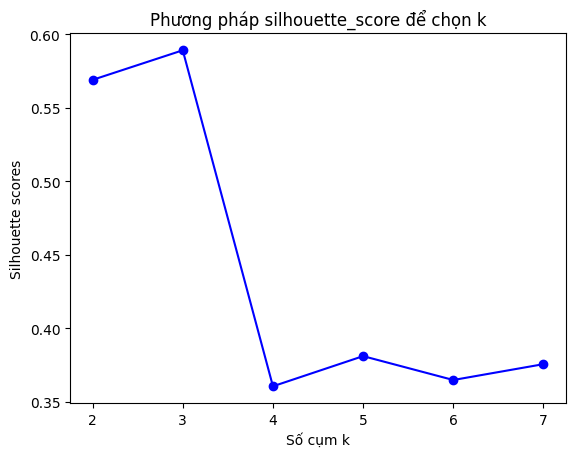

In [88]:
# vẽ biểu đồ
plt.plot(K, scores, 'bo-')
plt.xlabel('Số cụm k')
plt.ylabel('Silhouette scores')
plt.title('Phương pháp silhouette_score để chọn k')
plt.show()

#### Tìm k theo phương pháp elbow

K=2: WSSSE = 1.3704


c:\Users\gnngu\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gnngu\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gnngu\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gnngu\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\

K=3: WSSSE = 1.2923
K=4: WSSSE = 1.0412
K=5: WSSSE = 0.9662
K=6: WSSSE = 0.8743
K=7: WSSSE = 0.8255
K=8: WSSSE = 0.7661
K=9: WSSSE = 0.7409


c:\Users\gnngu\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gnngu\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\gnngu\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


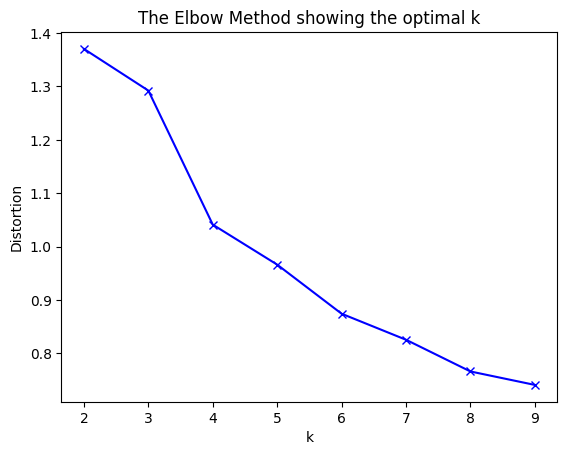

In [89]:
from scipy.spatial.distance import cdist
distortions = []
K=range(2,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=30)
    kmeanModel.fit(X_scaled)
    # Tính WSSSE/Distortion
    current_distortion = sum(np.min(cdist(X_scaled, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_scaled.shape[0]
    distortions.append(current_distortion)
    print(f"K={k}: WSSSE = {current_distortion:.4f}")

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [90]:
# Từ kết quả silhouette_score và elbow, chọn k = 3
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

c:\Users\gnngu\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [91]:
df['cluster'].value_counts()

0    6046
1     528
2     291
Name: cluster, dtype: int64

In [92]:
# Lấy nhãn cụm cho mỗi dòng dữ liệu
cluster_labels = kmeans.labels_

In [93]:
# Thêm cột nhãn cụm vào DataFrame ban đầu
df['kmeans_cluster'] = cluster_labels

In [94]:
df.head()

,id,Tiêu đề,Giá,Khoảng giá min,Khoảng giá max,Địa chỉ,Mô tả chi tiết,Thương hiệu,Dòng xe,Năm đăng ký,...,Trọng lượng,Href,log_gia,Thương hiệu_encoded,Dòng xe_encoded,Loại xe_encoded,Dung tích xe_encoded,Xuất xứ_encoded,cluster,kmeans_cluster
0,1,"Bán Vespa Sprint 125cc 2024 xanh dương, xe đẹp...",66.0,72.53,85.14,"Phường Bến Thành, Quận 1, Tp Hồ Chí Minh",Bán xe #Vespa Sprint 125cc. Mua mới tại #Topco...,Piaggio,Vespa,2024.0,...,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,4.204693,20,144,1,0,7,0,0
1,2,🔥🔥SH 150i Thắng ABS 2019 BSTP Chính Chủ,79.5,62.76,73.68,"Phường Tân Định, Quận 1, Tp Hồ Chí Minh","_Bán SH 150i Thắng ABS 2019 Xám Bạc, Úp Team X...",Honda,SH,2019.0,...,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,4.388257,11,114,1,0,7,0,0
2,3,CC Vision Thể Thao 2023 Đen+bộ đèn Demi audi A7,37.0,28.00,32.86,"Phường Cầu Kho, Quận 1, Tp Hồ Chí Minh",Chính chủ bán Vision phiên bản Thể Thao 2023 Đ...,Honda,Vision,2023.0,...,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,3.637586,11,146,1,0,7,0,0
3,4,Vespa Sprint 2019 -125- Đen Đỏ Sport -CHÍNH ...,45.0,43.10,50.60,"Phường Bến Nghé, Quận 1, Tp Hồ Chí Minh",XE CÁ NHÂN BÁN - XE DO EM ĐỨNG TÊN CHÍNH C...,Piaggio,Vespa,2019.0,...,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,3.828641,20,144,1,0,7,0,0
4,5,Xe tay ga Yamaha Latte 125 – Đăng ký 2021,23.0,17.02,19.98,"Phường Tân Định, Quận 1, Tp Hồ Chí Minh",🛵 Thông tin xe:\n\nDòng xe tay ga cao cấp Yama...,Yamaha,Latte,2021.0,...,> 50 kg,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,3.178054,33,75,1,0,2,0,0


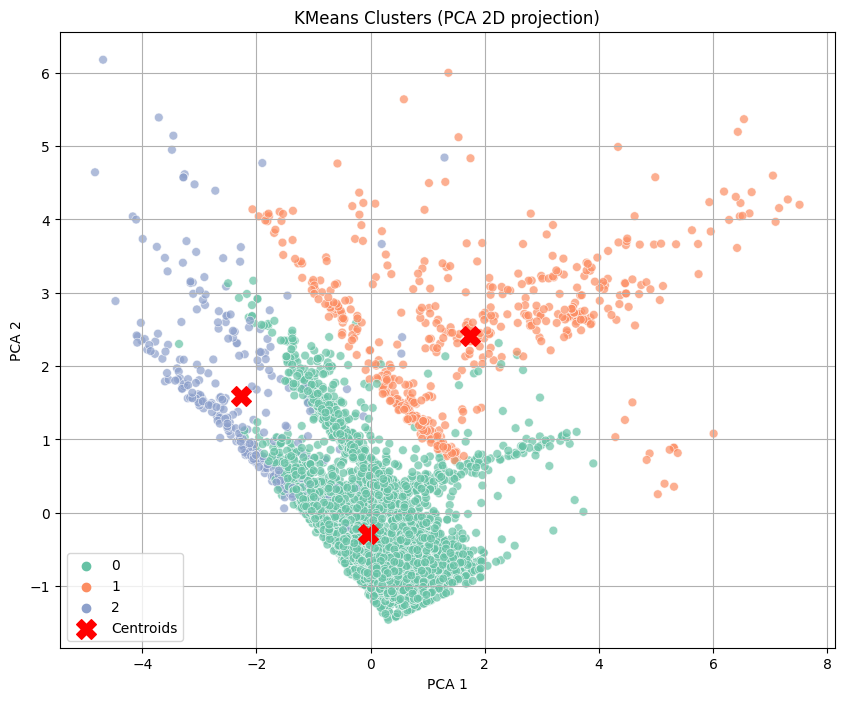

In [95]:
# TRỰC QUAN HÓA KẾT QUẢ PHÂN CỤM BẰNG PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=['pca1', 'pca2'], index=df.index)
df_pca['cluster'] = df['cluster'].astype(int)

# Centroids in PCA space
centers_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='pca1', y='pca2', hue='cluster', palette='Set2', alpha=0.7, s=40)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title('KMeans Clusters (PCA 2D projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.show()

In [96]:
# Tính silhouette cho từng cụm
from sklearn.metrics import silhouette_samples

sil_samples = silhouette_samples(X_scaled, cluster_labels)

In [97]:
import numpy as np

unique_clusters = np.unique(cluster_labels)

silhouette_per_cluster = {}
counts = df['kmeans_cluster'].value_counts()
for c in unique_clusters:
    silhouette_per_cluster[c] = np.mean(sil_samples[cluster_labels == c])

for cluster, score in silhouette_per_cluster.items():
    count = counts.get(cluster, 0)
    print(f"Cluster {cluster}: Silhouette = {score:.3f}, Count = {count}")

print(f"Silhouette tổng thể {np.mean(sil_samples):.3f}") 

Cluster 0: Silhouette = 0.630, Count = 6046
Cluster 1: Silhouette = 0.218, Count = 528
Cluster 2: Silhouette = 0.412, Count = 291
Silhouette tổng thể 0.589


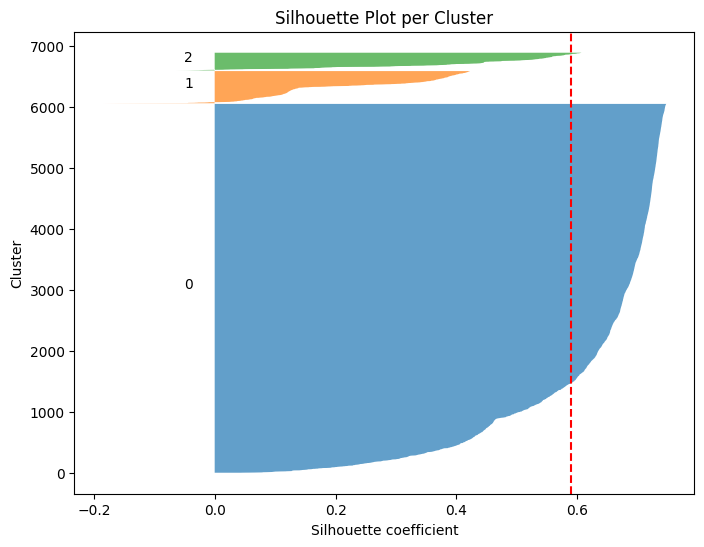

In [98]:
# Vẽ biểu đồ silhouette cho từng cụm
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))

y_lower = 10
for i in unique_clusters:
    cluster_sil_vals = sil_samples[cluster_labels == i]
    cluster_sil_vals.sort()

    size_cluster_i = cluster_sil_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_sil_vals,
        alpha=0.7
    )

    plt.text(-0.05, y_lower + size_cluster_i / 2, str(i))
    y_lower = y_upper + 10

plt.axvline(x=np.mean(sil_samples), color="red", linestyle="--")
plt.xlabel("Silhouette coefficient")
plt.ylabel("Cluster")
plt.title("Silhouette Plot per Cluster")
plt.show()

In [99]:
cols = ['Giá','Số Km đã đi', 'Dung tích xe_encoded', 'Năm đăng ký']

In [100]:
print(df.groupby('kmeans_cluster')[cols].mean())

                      Giá    Số Km đã đi  Dung tích xe_encoded  Năm đăng ký
kmeans_cluster                                                             
0               25.407013   39738.730566              0.097916  2014.285974
1               65.153839   30516.848485              2.412879  2013.804924
2               16.957687  641115.319588              0.302405  2010.690722


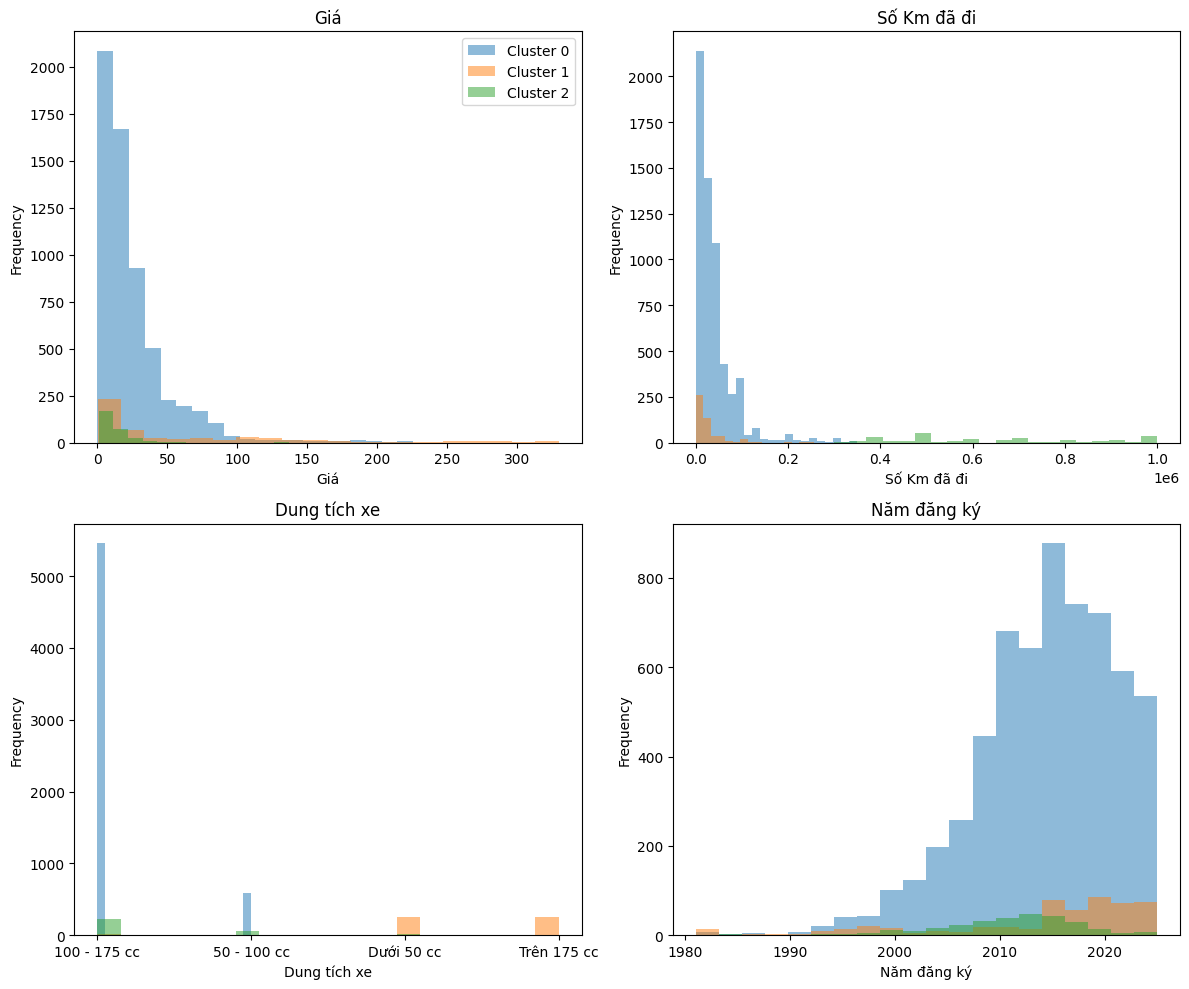

In [101]:
# vẽ histogram cho từng cụm
import matplotlib.pyplot as plt

cols = ['Giá','Số Km đã đi', 'Dung tích xe', 'Năm đăng ký']
clusters = df['cluster'].unique()

plt.figure(figsize=(12, 10))

for i, feature in enumerate(cols, 1):
    plt.subplot(2, 2, i) 
    
    for c in clusters:
        subset = df[df['cluster'] == c][feature]
        plt.hist(subset, bins=20, alpha=0.5, label=f'Cluster {c}')
    
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    
    if i == 1:
        plt.legend()

plt.tight_layout()
plt.show()

Đánh giá:
- Biểu đồ cho thấy có phân cụm rõ ràng và tương đối tốt ở Cluster 0, 1. Cluster 3 chưa rõ, còn chồng lấn và có các vùng giao nhau

 ### Gaussian Mixture Model (GMM)

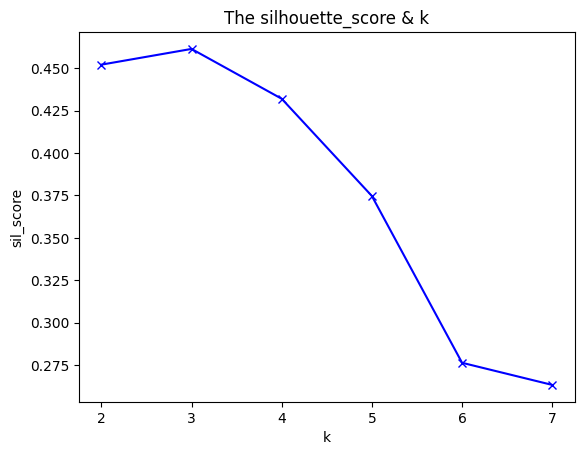

[0.4520615244339339, 0.46133633562684356, 0.43196132612727245, 0.3746469639199448, 0.27634749204602976, 0.2632998036384949]
We have max silhouette score at k=  3


In [102]:
from sklearn.metrics import silhouette_score
scores=[]
K = range(2,8)
for k in K:
    gmmModel = GaussianMixture(n_components=k)
    gmmModel.fit(X_scaled)
    scores.append(silhouette_score(X_scaled, gmmModel.predict(X_scaled)))

# Plot 
plt.plot(K, scores, 'bx-')
plt.xlabel('k')
plt.ylabel('sil_score')
plt.title('The silhouette_score & k')
plt.show()
# Calculate k   
print(scores)
id_max =np.argmax(scores)    
print("We have max silhouette score at k= ",id_max+2 )

K=2: WSSSE = 1.3703
K=3: WSSSE = 1.2867
K=4: WSSSE = 1.1571
K=5: WSSSE = 1.0965
K=6: WSSSE = 0.9404
K=7: WSSSE = 0.9125
K=8: WSSSE = 0.8685
K=9: WSSSE = 0.8649


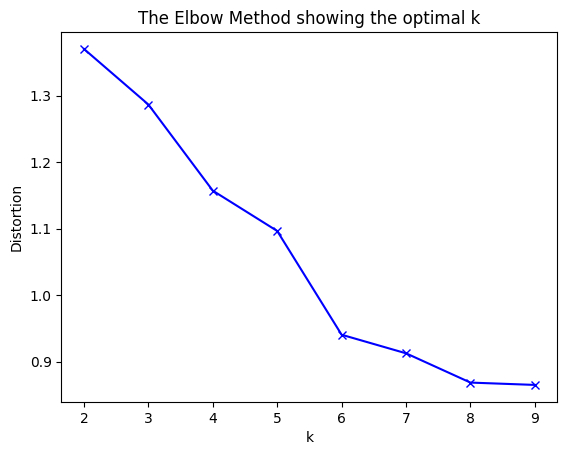

In [103]:
from scipy.spatial.distance import cdist
distortions = []
K=range(2,10)
for k in K:
    gmmModel = GaussianMixture(n_components=k)
    gmmModel.fit(X_scaled)
    # Tính chỉ số tương tự WSSSE
    current_distortion_gmm = sum(np.min(cdist(X_scaled, gmmModel.means_, 'euclidean'), axis=1)) / X_scaled.shape[0]
    distortions.append(current_distortion_gmm)
    print(f"K={k}: WSSSE = {current_distortion_gmm:.4f}")

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [104]:
# select components = 3
gmm = GaussianMixture(n_components=3)
gmmModel = gmm.fit(X_scaled)

In [105]:
types = gmmModel.predict(X_scaled)
print(types)

[2 2 2 ... 2 2 2]


In [106]:
print(gmmModel.weights_)

[0.15474482 0.08654775 0.75870743]


In [107]:
print(gmmModel.means_)

[[-0.44485806  1.19672346  0.72705981 -0.77361276]
 [ 1.70210945 -0.17392007  2.20972913  0.21735803]
 [-0.10343152 -0.22424238 -0.40035962  0.13299029]]


In [108]:
# Lấy nhãn cụm cho mỗi dòng dữ liệu
gmm_cluster_labels = gmmModel.predict(X_scaled)

In [109]:
# Thêm cột nhãn cụm vào DataFrame ban đầu
df['gmm_cluster'] = gmm_cluster_labels

In [110]:
df.head()

,id,Tiêu đề,Giá,Khoảng giá min,Khoảng giá max,Địa chỉ,Mô tả chi tiết,Thương hiệu,Dòng xe,Năm đăng ký,...,Href,log_gia,Thương hiệu_encoded,Dòng xe_encoded,Loại xe_encoded,Dung tích xe_encoded,Xuất xứ_encoded,cluster,kmeans_cluster,gmm_cluster
0,1,"Bán Vespa Sprint 125cc 2024 xanh dương, xe đẹp...",66.0,72.53,85.14,"Phường Bến Thành, Quận 1, Tp Hồ Chí Minh",Bán xe #Vespa Sprint 125cc. Mua mới tại #Topco...,Piaggio,Vespa,2024.0,...,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,4.204693,20,144,1,0,7,0,0,2
1,2,🔥🔥SH 150i Thắng ABS 2019 BSTP Chính Chủ,79.5,62.76,73.68,"Phường Tân Định, Quận 1, Tp Hồ Chí Minh","_Bán SH 150i Thắng ABS 2019 Xám Bạc, Úp Team X...",Honda,SH,2019.0,...,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,4.388257,11,114,1,0,7,0,0,2
2,3,CC Vision Thể Thao 2023 Đen+bộ đèn Demi audi A7,37.0,28.00,32.86,"Phường Cầu Kho, Quận 1, Tp Hồ Chí Minh",Chính chủ bán Vision phiên bản Thể Thao 2023 Đ...,Honda,Vision,2023.0,...,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,3.637586,11,146,1,0,7,0,0,2
3,4,Vespa Sprint 2019 -125- Đen Đỏ Sport -CHÍNH ...,45.0,43.10,50.60,"Phường Bến Nghé, Quận 1, Tp Hồ Chí Minh",XE CÁ NHÂN BÁN - XE DO EM ĐỨNG TÊN CHÍNH C...,Piaggio,Vespa,2019.0,...,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,3.828641,20,144,1,0,7,0,0,2
4,5,Xe tay ga Yamaha Latte 125 – Đăng ký 2021,23.0,17.02,19.98,"Phường Tân Định, Quận 1, Tp Hồ Chí Minh",🛵 Thông tin xe:\n\nDòng xe tay ga cao cấp Yama...,Yamaha,Latte,2021.0,...,https://xe.chotot.com/mua-ban-xe-may-quan-1-tp...,3.178054,33,75,1,0,2,0,0,2


### Hiển thị kết quả

In [111]:
from sklearn.decomposition import PCA

In [112]:
# Giảm chiều bằng PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

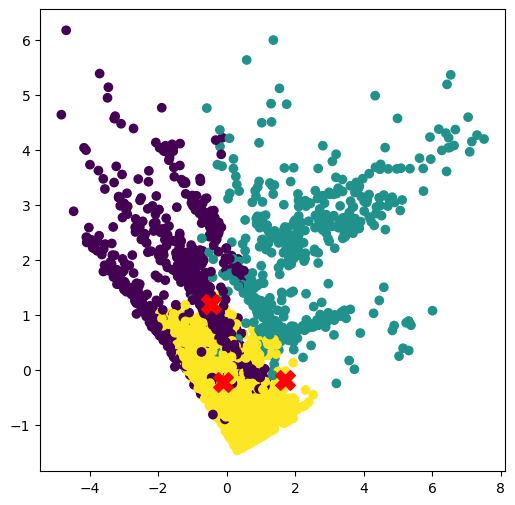

In [113]:
# plot mixture of Gaussians
plt.figure(figsize=(6,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=types) # 0, 1
plt.scatter(gmmModel.means_[:,0], gmmModel.means_[:,1], color="red", marker='X', s=200, label='GMM Cluster Centers (PCA)')
plt.show()

### Đánh giá từng cụm Sklearn GMM

In [114]:
# Tính silhouette cho từng cụm
from sklearn.metrics import silhouette_samples

sil_samples = silhouette_samples(X_scaled, gmm_cluster_labels)

In [115]:
import numpy as np

unique_clusters = np.unique(gmm_cluster_labels)

silhouette_per_cluster = {}
counts = df['gmm_cluster'].value_counts()
for c in unique_clusters:
    silhouette_per_cluster[c] = np.mean(sil_samples[gmm_cluster_labels == c])

for cluster, score in silhouette_per_cluster.items():
    count = counts.get(cluster, 0)
    print(f"Cluster {cluster}: Silhouette = {score:.3f}, Count = {count}")

Cluster 0: Silhouette = -0.071, Count = 1088
Cluster 1: Silhouette = 0.085, Count = 568
Cluster 2: Silhouette = 0.583, Count = 5209


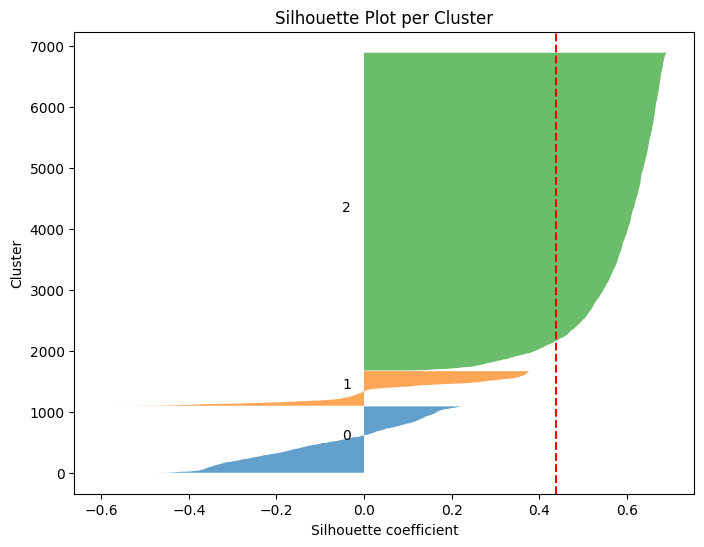

In [116]:
# Vẽ biểu đồ silhouette cho từng cụm
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))

y_lower = 10
for i in unique_clusters:
    cluster_sil_vals = sil_samples[gmm_cluster_labels == i]
    cluster_sil_vals.sort()

    size_cluster_i = cluster_sil_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_sil_vals,
        alpha=0.7
    )

    plt.text(-0.05, y_lower + size_cluster_i / 2, str(i))
    y_lower = y_upper + 10

plt.axvline(x=np.mean(sil_samples), color="red", linestyle="--")
plt.xlabel("Silhouette coefficient")
plt.ylabel("Cluster")
plt.title("Silhouette Plot per Cluster")
plt.show()

In [117]:
cols = ['Giá','Số Km đã đi', 'Dung tích xe_encoded', 'Năm đăng ký']

In [118]:
print(df.groupby('gmm_cluster')[cols].mean())

                   Giá    Số Km đã đi  Dung tích xe_encoded  Năm đăng ký
gmm_cluster                                                             
0            12.026892  223533.786765              0.788603  2008.695772
1            92.752225   41822.382042              1.929577  2015.873239
2            24.415088   33783.441352              0.000000  2015.030908


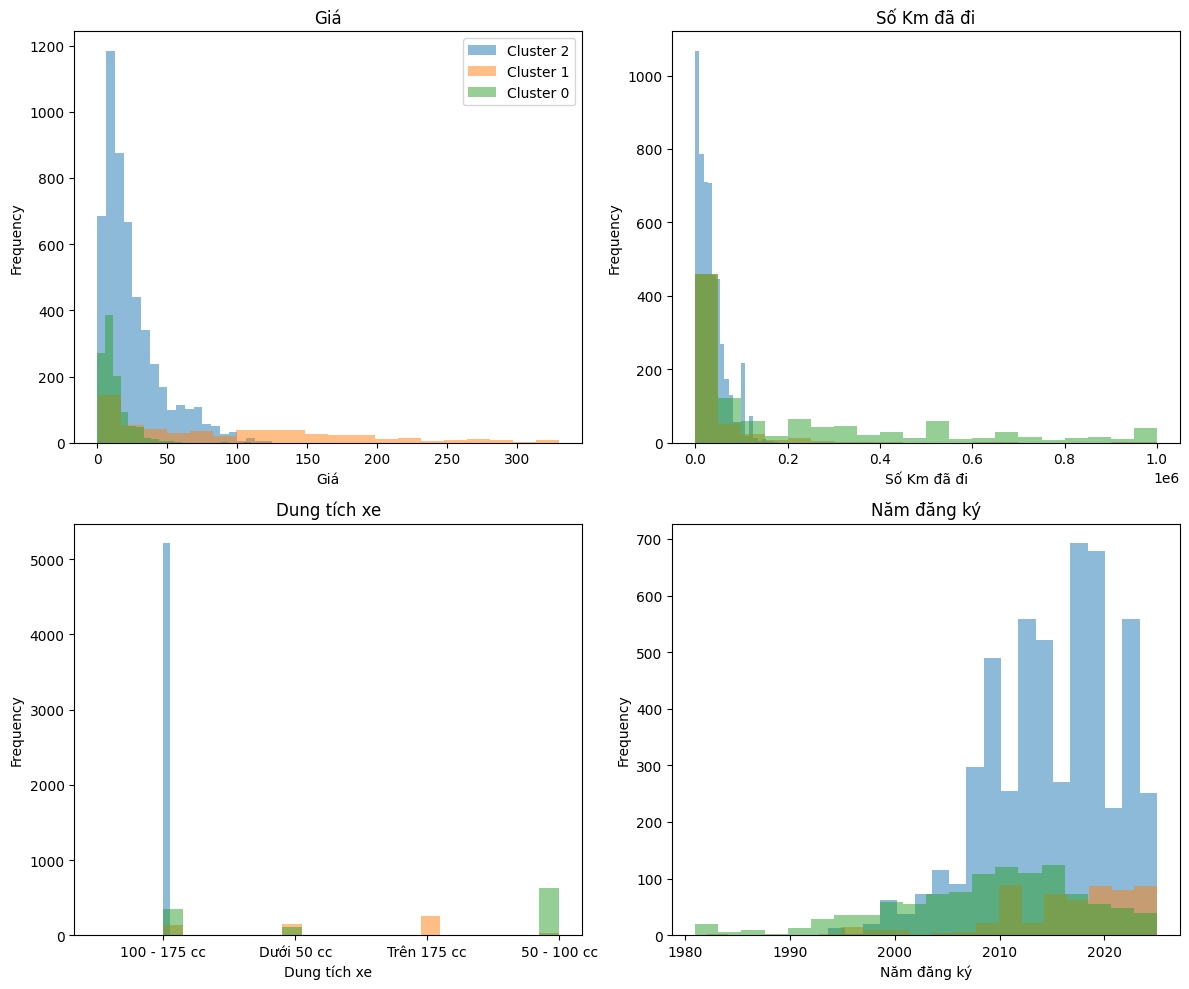

In [119]:
# vẽ histogram cho từng cụm
import matplotlib.pyplot as plt

cols = ['Giá','Số Km đã đi', 'Dung tích xe', 'Năm đăng ký']
clusters = df['gmm_cluster'].unique()

plt.figure(figsize=(12, 10))

for i, feature in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    
    for c in clusters:
        subset = df[df['gmm_cluster'] == c][feature]
        plt.hist(subset, bins=20, alpha=0.5, label=f'Cluster {c}')
    
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    
    if i == 1:
        plt.legend()

plt.tight_layout()
plt.show()

Đánh giá:
- Biểu đồ cho thấy có phân cụm rõ ràng ở cluster 0, nhưng cluster 1 và 2 còn chưa rõ, còn bị chồng lấn
- Số lượng các cụm không đồng đều, tập trung ở cluster 0 và 2

### Agglomerative Clustering

In [17]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(
    n_clusters=3,
    linkage='ward'
)

df['agg_cluster'] = agg.fit_predict(X_scaled)

In [18]:
df['agg_cluster'].value_counts()

agg_cluster
0    6359
2     296
1     210
Name: count, dtype: int64

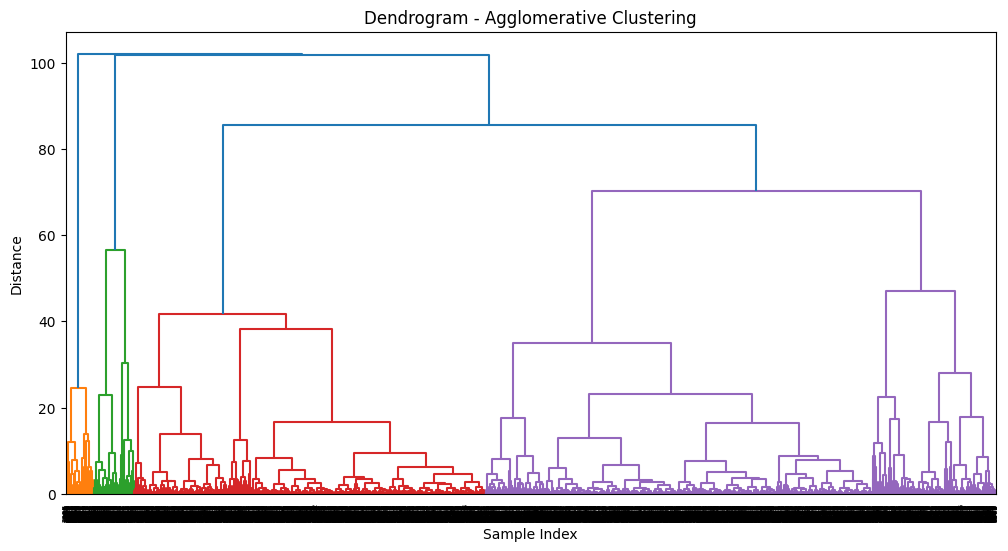

In [19]:
# Vẽ dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked)
plt.title("Dendrogram - Agglomerative Clustering")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

In [20]:
# Tìm giá trị Silhouette score tổng thể
from sklearn.metrics import silhouette_score

agg_score = silhouette_score(X_scaled, df['agg_cluster'])
print(f"Silhouette Score = {agg_score:.3f}")

Silhouette Score = 0.625


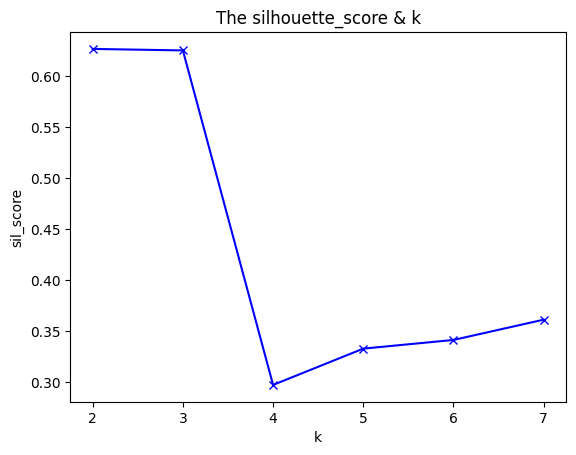

0.6254905614899261
We have max silhouette score at k=  2


In [25]:
agg_scores=[]
K = range(2,8)
for k in K:
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    aggModel = agg.fit_predict(X_scaled)
    agg_scores.append(silhouette_score(X_scaled, agg.fit_predict(X_scaled)))

# Plot 
plt.plot(K, agg_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('sil_score')
plt.title('The silhouette_score & k')
plt.show()
# Calculate k   
print(agg_score)
id_max =np.argmax(agg_scores)    
print("We have max silhouette score at k= ",id_max+2 )

In [27]:
# Silhouette theo từng cụm
import numpy as np
from sklearn.metrics import silhouette_samples

sil_values = silhouette_samples(X_scaled, df['agg_cluster'])
df['sil_value'] = sil_values

silhouette_per_cluster = df.groupby('agg_cluster')['sil_value'].mean()
print(silhouette_per_cluster.round(3))
#print(f"Cluster {cluster}: Silhouette = {silhouette_per_cluster:.3f}, Count = {count}")

agg_cluster
0    0.645
1    0.516
2    0.282
Name: sil_value, dtype: float64


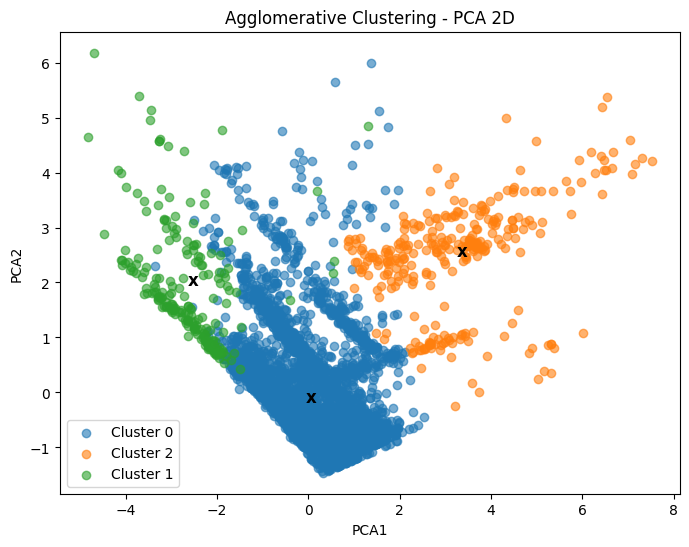

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df['pca1'] = pca_result[:,0]
df['pca2'] = pca_result[:,1]

centroids = df.groupby('agg_cluster')[['pca1', 'pca2']].mean()
# centroids

plt.figure(figsize=(8,6))
for c in df['agg_cluster'].unique():
    subset = df[df['agg_cluster']==c]
    plt.scatter(subset['pca1'], subset['pca2'], label=f"Cluster {c}", alpha=0.6)

# Ghi nhãn centroid
for idx, row in centroids.iterrows():
    plt.text(row['pca1'], row['pca2'], 'x', fontsize=12, weight='bold')

plt.title("Agglomerative Clustering – PCA 2D with Centroids")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

plt.legend()
plt.title("Agglomerative Clustering - PCA 2D")
plt.show()


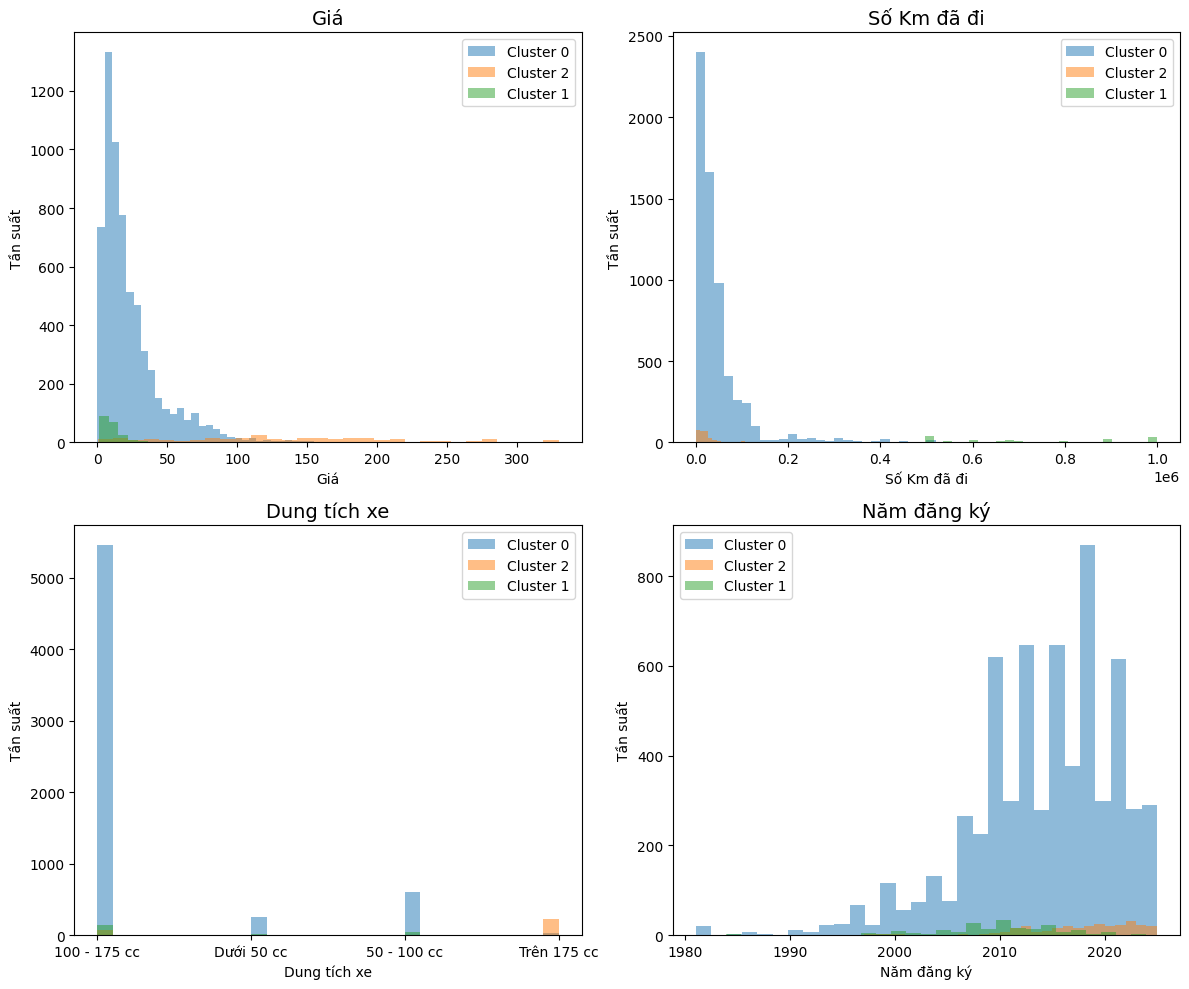

In [30]:
# Vẽ biểu đồ phân bố dữ liệu
import matplotlib.pyplot as plt
cols = ['Giá', 'Số Km đã đi', 'Dung tích xe', 'Năm đăng ký']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

clusters = df['agg_cluster'].unique()

for i, col in enumerate(cols):
    ax = axes[i]
    
    # Vẽ histogram theo cluster
    for c in clusters:
        data = df[df['agg_cluster'] == c][col]
        ax.hist(data, bins=30, alpha=0.5, label=f'Cluster {c}')
    
    ax.set_title(f'{col}', fontsize=14)
    ax.set_xlabel(col)
    ax.set_ylabel('Tần suất')
    ax.legend()

plt.tight_layout()
plt.show()

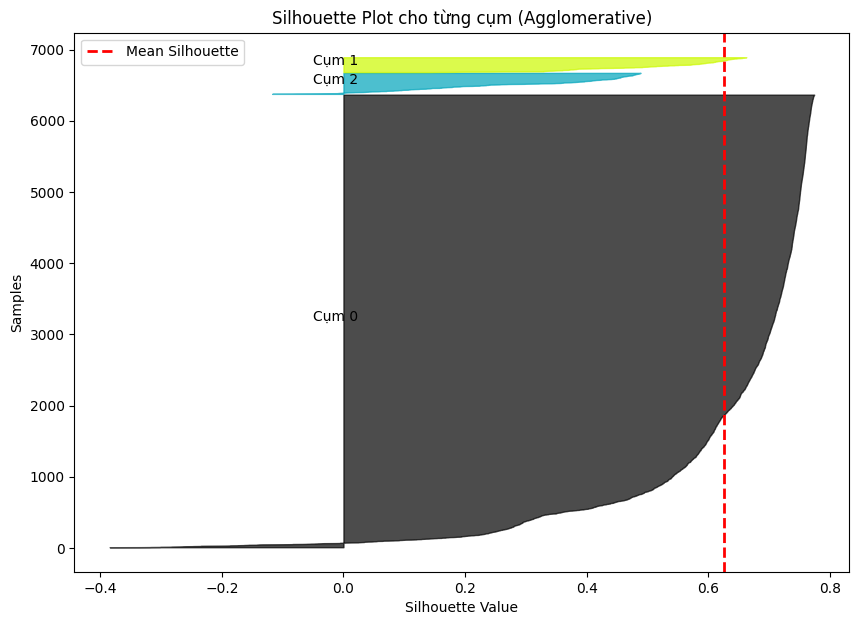

In [31]:
import matplotlib.pyplot as plt
import numpy as np

agg_clusters = np.unique(df['agg_cluster'])
n_clusters = len(agg_clusters)

plt.figure(figsize=(10, 7))

y_lower = 10  # khoảng cách từ mép dưới

for i, c in enumerate(clusters):
    # lấy silhouette của cụm c
    sil_cluster = df[df['agg_cluster'] == c]['sil_value'].values

    # sắp xếp tăng dần để vẽ đẹp
    sil_cluster.sort()

    size = sil_cluster.shape[0]
    y_upper = y_lower + size

    # vẽ filled area
    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0, sil_cluster,
        facecolor=color,
        edgecolor=color,
        alpha=0.7
    )

    # nhãn cụm
    plt.text(-0.05, y_lower + size / 2, f"Cụm {c}")

    y_lower = y_upper + 10  # khoảng cách giữa các cụm

# Vẽ đường silhouette trung bình tổng thể
sil_overall = silhouette_score(X_scaled, df['agg_cluster'])
plt.axvline(x=sil_overall, color="red", linestyle="--", linewidth=2, label="Mean Silhouette")

plt.xlabel("Silhouette Value")
plt.ylabel("Samples")
plt.title("Silhouette Plot cho từng cụm (Agglomerative)")
plt.legend()
plt.show()

## Dữ đoán trên dữ liệu mới

In [32]:
from sklearn.neighbors import KNeighborsClassifier
# new_point = [gia, km, dung_tich_encoded, nam]
new_point = [80, 570000, 2, 2020]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_scaled, df['agg_cluster'])

new_point_scaled = scaler.transform([new_point])
pred_cluster = knn.predict(new_point_scaled)
print("Điểm mới thuộc cụm:", pred_cluster[0])

Điểm mới thuộc cụm: 1


C:\Users\iywnt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
